In [124]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt

twenty_train = fetch_20newsgroups(subset='train', shuffle=True, remove = ('headers', 'footers'))
targets_train = twenty_train['target']

twenty_test = fetch_20newsgroups(subset = 'test', remove = ('headers', 'footers'))
targets_test = twenty_test['target']

#with open('train_data.txt', 'rt') as file: train_data = file.read().splitlines()
#with open('test_data.txt', 'rt') as file: test_data = file.read().splitlines() 
    
train_data = twenty_train['data']
test_data = twenty_test['data']

In [126]:

log = np.vectorize(lambda n: np.log(n) if n else -100e3)
class NewsClassifier:
    def __init__(self, **kwargs):
        self.tfidf = TfidfVectorizer(**kwargs, stop_words = 'english')
        
        self.got_hist = False
        
    def train(self, train_set, targets):
        
        self.got_hist = False
        
        self.train_set = train_set
        self.targets_train = targets

        self.groups = np.unique(targets)
        
        self.fitted_train = self.tfidf.fit_transform(train_set)
        self.priori = np.mean(self.targets_train == self.groups.reshape(-1, 1), axis = 1)
        
        self.probabilities = np.zeros((20, self.fitted_train.shape[1]))
        
        for i, group in enumerate(self.groups):
            row = self.fitted_train[self.targets_train == group].sum(axis = 0)
            #row += row[row > 0].min()
            self.probabilities[i] = row / row.sum()
            
    def df_hist(self, **kwargs):
        if not self.got_hist:
            df = self.fitted_train.getnnz(axis = 0) / self.targets_train.size
        
            self.hist_height, self.hist_x, container = plt.hist(df * 100, bins = int(np.sqrt(df.size)), **kwargs)
            self.got_hist = True
        else:
            plt.bar(self.hist_x, self.hist_height)
        
        plt.yscale('log')
        plt.xlabel('%')
        plt.ylabel('Cantidad de palabras')
        
            
    def score(self, test_set, targets):
        
        pred_test = self.predict(test_set)
        
        return np.mean(pred_test == targets)
    
    def predict(self, input_data):
        fitted_test = self.tfidf.transform(input_data)
        probs_test = fitted_test.dot(log(self.probabilities).T) + np.log(self.priori)
        pred_test = self.groups[np.argmax(probs_test, axis = 1)]
        
        return pred_test

In [121]:
max_df = np.arange(.08, .15, .01)
smooth_idf = np.array([True, False])
use_idf = np.array([True, False])
sublinear_tf = np.array([True, False])
norm = np.array(['l1', 'l2'])

res = np.zeros((max_df.size, smooth_idf.size, use_idf.size, sublinear_tf.size, norm.size))

itr = 1
for i, df in enumerate(max_df):
    for j, smooth in enumerate(smooth_idf):
        for z, idf in enumerate(use_idf):
            for k, subtf in enumerate(sublinear_tf):
                for l, nrm in enumerate(norm):
                    classifier = NewsClassifier(max_df = df, smooth_idf = smooth, use_idf = idf, sublinear_tf = subtf, norm = nrm)
                    
                    classifier.train(train_data, targets_train)
                    print(f'{itr} of {max_df.size * smooth_idf.size * use_idf.size * sublinear_tf.size * norm.size}')
                    
                    res[i, j, z, k, l] = classifier.score(test_data, targets_test)
                    
                    itr += 1
        
best = res.max()
argmax = np.argwhere(res == best)[0]
print(f'Best max_df: {max_df[argmax[0]]}')
print(f'Best smoothing: {smooth_idf[argmax[1]]}')
print(f'Best use_idf: {use_idf[argmax[2]]}')
print(f'Best subtf: {sublinear_tf[argmax[3]]}')
print(f'Best norm: {norm[argmax[4]]}')
print(f'Best result: {best}')

1 of 112
2 of 112
3 of 112
4 of 112
5 of 112
6 of 112
7 of 112
8 of 112
9 of 112
10 of 112
11 of 112
12 of 112
13 of 112
14 of 112
15 of 112
16 of 112
17 of 112
18 of 112
19 of 112
20 of 112
21 of 112
22 of 112
23 of 112
24 of 112
25 of 112
26 of 112
27 of 112
28 of 112
29 of 112
30 of 112
31 of 112
32 of 112
33 of 112
34 of 112
35 of 112
36 of 112
37 of 112
38 of 112
39 of 112
40 of 112
41 of 112
42 of 112
43 of 112
44 of 112
45 of 112
46 of 112
47 of 112
48 of 112
49 of 112
50 of 112
51 of 112
52 of 112
53 of 112
54 of 112
55 of 112
56 of 112
57 of 112
58 of 112
59 of 112
60 of 112
61 of 112
62 of 112
63 of 112
64 of 112
65 of 112
66 of 112
67 of 112
68 of 112
69 of 112
70 of 112
71 of 112
72 of 112
73 of 112
74 of 112
75 of 112
76 of 112
77 of 112
78 of 112
79 of 112
80 of 112
81 of 112
82 of 112
83 of 112
84 of 112
85 of 112
86 of 112
87 of 112
88 of 112
89 of 112
90 of 112
91 of 112
92 of 112
93 of 112
94 of 112
95 of 112
96 of 112
97 of 112
98 of 112
99 of 112
100 of 112
101 of 1

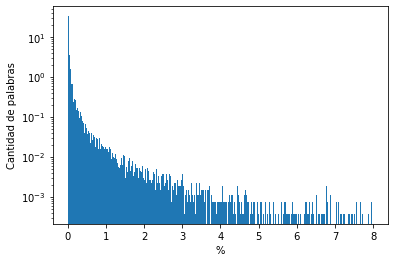

In [127]:
classifier = NewsClassifier(max_df = .08, smooth_idf = True, use_idf = False, sublinear_tf = True)
                    
classifier.train(train_data, targets_train)
classifier.df_hist(density = True)